In [55]:
from pathlib import Path
from glob import iglob

import altair as alt
import pandas as pd

In [69]:
colo829bl_10x = pd.read_csv("../data/processed/COLO829BL-10X-hg38.hist.csv")
colo829t_10x = pd.read_csv("../data/processed/COLO829T-10X-hg38.hist.csv")
colo829bl = pd.read_csv("../data/processed/COLO829BL-hg38.hist.csv")
colo829t = pd.read_csv("../data/processed/COLO829T-hg38.hist.csv")

datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]

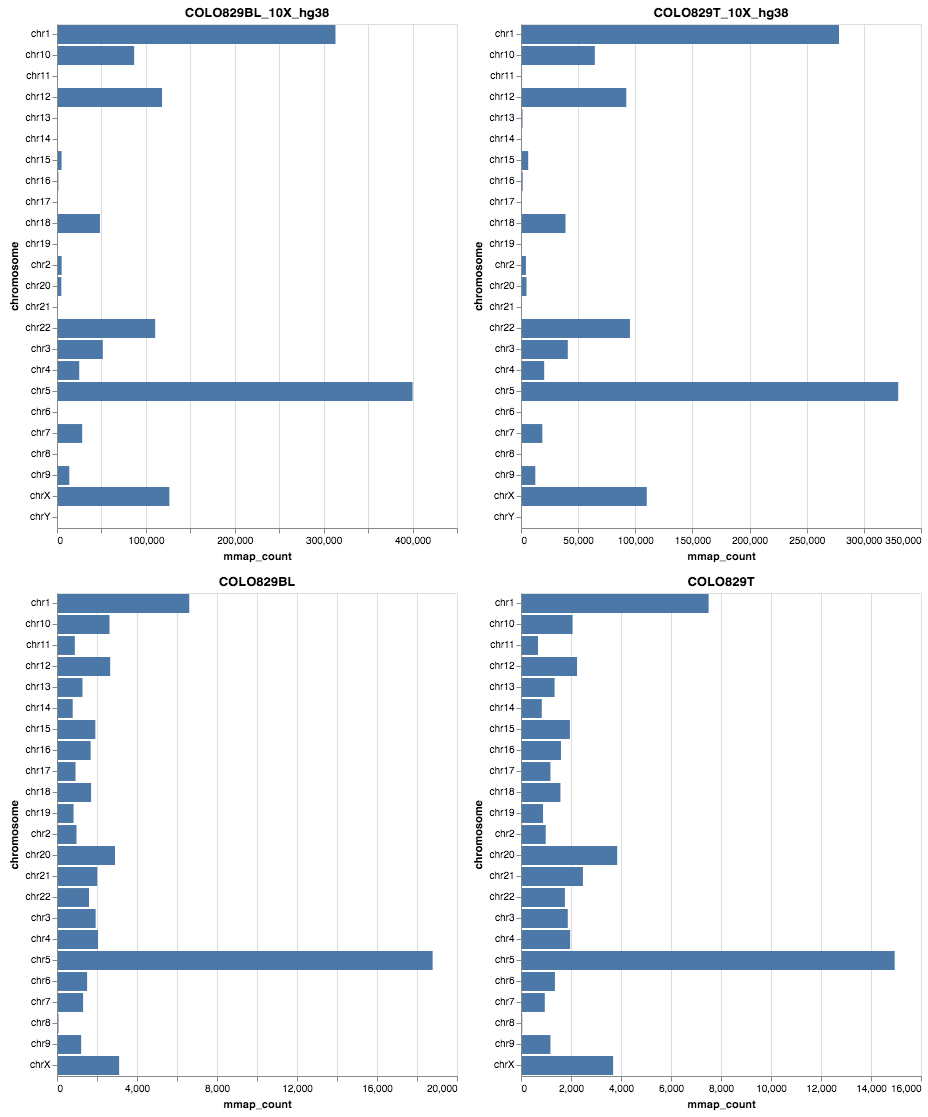

In [71]:
charts = []

for ds in datasets:
    charts.append(alt.Chart(ds).mark_bar().encode(
        x = 'mmap_count',
        y = 'chromosome'
    ))

charts[0].title = "COLO829BL_10X_hg38"
charts[1].title = "COLO829T_10X_hg38"
charts[2].title = "COLO829BL"
charts[3].title = "COLO829T"

(charts[0] | charts[1]) & (charts[2] | charts[3])